# oct arjcaps analysis

The purpose of this document is to showcase how we train, validate and analyse the oct capsnet. Note that this is on top of the scripts in seg_model, which are related to building the capsnet body.

In [1]:
import os
from fastai.vision import *
from fastai.callbacks import * 

In [2]:
os.chdir(Path('/workspace/oct_ca_seg/'))

In [3]:
#export
from fastai.vision import *
from fastai.metrics import *
import torch.nn as nn
import numpy as np
import PIL.Image as pil
import torch.functional as F
from fastai.utils.mem import *
from pathlib import Path
import itertools
import sys
import seg_model.src.model as m
import skimage.transform as skitra
from oct_ca.exp.nb_caps import one_group_selective_freeze

In [4]:
data_path = Path('/workspace/oct_ca_seg/data_oct')

In [5]:
valid_names = list(np.load(Path('/workspace/oct_ca_seg/runsaves/Final1-pawsey/analysis/testNAMES.npy')))

In [6]:
for i, name in enumerate(valid_names):
    name = Path(data_path/('images/' + name[:-4] + '.jpg'))
    valid_names[i] = name

In [7]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_oct_mask(fn)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

I have a pretrained capsnet body, so I also need to load which images I used the model on to train and validate, it wouldn't be fair to start validating on images the model has previously seen in the training phase.

In [8]:
%%time
def load_name_sets(path, valid_names):
    allnames = get_image_files(path)
    train = []
    valid= []
    for i, name in enumerate(allnames):
        if name in valid_names: valid.append(name)
        else: train.append(name)
    return train, valid
            
train, valid = load_name_sets(data_path/'images', valid_names)

CPU times: user 13.8 s, sys: 0 ns, total: 13.8 s
Wall time: 13.8 s


path_img = data_path/'images'

get_y_fn = lambda x: data_path/'labels'/x.name

saved_us, saved_stds = ([0.2158, 0.1964, 0.1908], [0.0418, 0.0194, 0.0138])
saved_stats = (saved_us, saved_stds)

src = (SegItemListCustom.from_folder(path_img)
       .split_by_idxs(train_idx=trainidx, valid_idx=valididx)
       .label_from_func(get_y_fn,classes=['background','lumen']))

metrics=[acc,sens,spec,mydice]
size=256
bs=1
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=4)
        .normalize(saved_stats))

### Loading Original Dataset

In [9]:
from seg_model.nbs.useful.dataset import *

In [10]:
opts = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'cuda' : True,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'start_size': (256, 256),
'device': 'cuda',
'input_images': [0,1,2],
'transforms':False,      
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 1,
'inputchannels': 3,
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'uptype': 'deconv',
}

In [11]:
optsagain = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'comet': False,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'device': 'cuda',
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 2,
'inputchannels': 3,
'la': 0.1,
'lb': 1,
'lc': 0.05,
'loadcheckpoint': '/workspace/oct_ca_seg/runsaves/Final1-pawsey/checkpoints/checkpoint.pt',
'location': 'pawsey',
'logging': True,
'lr': 0.0008,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'nThreads': 8,
'name': 'Final1-pawsey',
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'runsaves_dir': '/group/pawsey0271/abalaji/projects/oct_ca_seg/run_saves',
'save': True,
'sgamma': 0.8,
'sstep': 50,
'start_size': (256, 256),
'test': True,
'train': True,
'transforms': True,
'uptype': 'deconv',
'val': True,
'verbose': True}

### Loading capsnet body options.

In [12]:
class Options():
    def __init__(self, dictionary):
        
        for k,v in dictionary.items():
            setattr(self, k, v)

In [13]:
opts = Options(opts)
optsagain = Options(optsagain)

# Dataset

In [14]:
def normalize(octimage):
    means = octimage.view(3,-1).mean(-1)
    stds = octimage.view(3,-1).std(-1)
    return (octimage - means[:,None,None])/stds[:,None,None]

In [15]:
#dataset class
class OCTDataset(Dataset):
    """
    First we create a dataset that will encapsulate our data. It has 3 special 
    functions which will be explained as they go. We will pass this dataset object
    to the torch dataloader object later which will make training easier.
    """
    def __init__ (self,
                  main_data_dir,
                  name_list,
                  start_size,
                  cropped_size,
                  transform,
                  input_images,
                  cuda):
        self.nl = name_list
        self.main_data_dir = main_data_dir
        self.start_size = start_size
        self.transform = transform
        self.cropped_size = cropped_size
        self.input_images = input_images
        self.cuda = cuda
        
        self.rcrop = RandomCrop(self.cropped_size)
        self.phflip = np.random.rand()
        self.pvflip = np.random.rand()
        self.spnoise = SPNoise(1)
        
        '''
        #iterate through the 2d images and get all their names
        name_list = []
        for im in os.listdir(os.path.join(self.main_data_dir, 'images')):
            filename = os.fsdecode(im)
            name_list.append(filename)
        ''' 
        self.name_list = name_list
        
    def visualise(self, idx):
        
        sample = self.__getitem__(idx)
        #print(sample['input'].size())
        #print(sample['label'].size())
        input_data = sample['input'].cpu().numpy()[0,:,:]
        l_data = sample['label'].cpu().numpy()[0,:,:]

        
        
        f, (axin, axl, ax1comb) = plt.subplots(1,3, sharey=True)
        f.subplots_adjust(hspace=0.3)
        plt.tight_layout()
        
        #plot image
        image = axin.imshow(input_data,
                            aspect = 'equal')
        f.colorbar(image, ax=axin, orientation='vertical', fraction = 0.05)
        
        axl.imshow(l_data,
                   aspect = 'equal')
        
        
        combined = input_data + 10 * l_data 
        
        ax1comb.imshow(combined, aspect = 'equal')
        plt.show()
        
    def __getitem__(self, idx):
        """This function will allow us to index the data object and it will 
        return a sample."""
        name = self.name_list[idx]
        
        #load data  
        label = np.array(pil.open(name.parent.parent/str('labels/' + name.name)))
        #print(Path('/workspace/oct_ca_seg/data_oct/labels/')/str(name))
        #print(label.shape)
        
        image = np.array(pil.open(name))
        
        image = image.astype(float)
        label = label.astype(float)
        #print(image.shape)
        
        #print(label.max())
        #print(Image.shape)
        if self.transform:
            
            ysize = self.start_size[0] + 20
            xsize = self.start_size[1] + 20
            image = skitransforms.resize(image, output_shape=(ysize, xsize))
            label = skitransforms.resize(label, output_shape=(ysize, xsize))
            
            
            #print(label.shape)
            #print(label.max())
            image, label = self.rcrop(image, label)
            #print(label.max())
            
            if self.phflip>0.5:
                #hflip
                image = np.flip(image, 1)
                label = np.flip(label, 1)    
                #print(label.max())
            #print(label.shape)
            
            if self.pvflip>0.5:
                #vflip
                image = np.flip(image, 0)
                label = np.flip(label, 0)
                #print(label.max())
            #print(label.shape)
            
            angle = np.random.randint(0,360)
            image = skitransforms.rotate(image, angle=angle, mode='reflect')
            label = skitransforms.rotate(label, angle=angle, mode='reflect')
            #print(label.max())
            #print(label.shape)
            
            if np.random.rand() > 0.9:
                image = self.spnoise(image)
            
            if np.random.rand() > 0.5:
                image = gaussian(image, sigma=1, mode='reflect')
            
            
        else:
            image = skitransforms.resize(image, output_shape= self.start_size)
            label = skitransforms.resize(label, output_shape= self.start_size)
        
        #image = np.expand_dims(preprocessing.scale(image[:,:,0]), -1)
        
        label = np.transpose(label.copy(), (2, 0, 1))
        image = np.transpose(image.copy(), (2, 0, 1))
        #og = preprocessing.MinMaxScaler(og)
        
        label = torch.tensor(label).float()
        
        label = torch.gt(label.sum(dim=0).unsqueeze(0), 200).float()
        
        image = torch.tensor(image).float()
        #print(image.size(), label.shape)
        image = normalize(image)
        
        
        sample = {'input': image[self.input_images],
                  'label': label,
                  'case_name': [str(name.name)]}

        return sample
    
    def __len__(self):    
        """This function is mandated by Pytorch and allows us to see how many 
        data points we have in our dataset"""
        return len(self.name_list)
    


In [16]:
oct_data_t = OCTDataset(data_path/'images', train, opts.start_size,opts.c_size,opts.transforms,opts.input_images, opts.cuda)
oct_data_v = OCTDataset(data_path/'images', valid, opts.start_size,opts.c_size,opts.transforms,opts.input_images, opts.cuda)

In [17]:
len(oct_data_t) 

9608

In [18]:
oct_load_t = DataLoader(oct_data_t, batch_size=1, shuffle=False)
oct_load_v = DataLoader(oct_data_v, batch_size=1, shuffle=False)

In [19]:
len(oct_data_t),len(oct_data_v)

(9608, 2403)

In [20]:
model = m.CapsNet(opts);
model.to(opts.device);

modelfake = m.CapsNet(optsagain);
modelfake.to(opts.device);

guassian stuff below

In [21]:
#export
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

In [22]:
class GaussianAndResizing(nn.Module):
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianAndResizing, self).__init__()
        self.smooth = GaussianSmoothing(channels, kernel_size, sigma, dim)
    
    def smoothing(self, x):
        xs = x.size()
        #print(x.size())
        x = x.permute(0,1,4,2,3).reshape([xs[0], int(xs[1]*xs[4]), xs[2], xs[3]])
        #print(x.size())
        x = self.smooth(x)
        x=F.pad(x, (2,0,2,0), 'reflect')
        #print(x.size())
        x = x.view([xs[0], int(xs[1]), int(xs[4]), xs[2], xs[3]]).permute(0,1,3,4,2)
        return x
    
    def forward(self,x):
        #print(self.smoothing(x).size())
        return self.smoothing(x)

### Add Gaussian filter inbetween last two layers to get rid of grid artefacts. 

In [23]:
model.get_abstract_caps_final2 = nn.Sequential(modelfake.get_abstract_caps_final2, GaussianAndResizing(32, 3, 2).to(opts.device))
model.get_abstract_caps_final1 = nn.Sequential(modelfake.get_abstract_caps_final1, GaussianAndResizing(64, 3, 2).to(opts.device))

In [24]:
model.load_state_dict(torch.load(Path('/workspace/oct_ca_seg/runsaves/capstunedarj1.pt')))

<All keys matched successfully>

In [25]:
del modelfake

### now I'm freezing the body and leaving only the last two layers for training.

In [27]:
model = one_group_selective_freeze(model, 'get_abstract_caps_final1')

### Metric definitions

In [26]:
def sens(c, l):
    n_targs=l.size()[0]
    c = c.argmin(dim=1).view(n_targs,-1).float()
    l=l.view(n_targs, -1).float()
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l) - inter
    return (inter/union).mean()

In [27]:
def spec(c, l):
    n_targs=l.size()[0]
    c = c.argmin(dim=1).view(n_targs,-1).float()
    l = l.view(n_targs,-1).float()
    c=1-c
    l=1-l
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l) - inter
    return (inter/union).mean()

In [28]:
def acc(c, l):
    n_targs=l.size()[0]
    c = c.argmin(dim=1).view(n_targs,-1).float()
    l = l.view(n_targs,-1)
    c = torch.sum(torch.eq(c,l).float(),dim=1)
    return (c/l.size()[-1]).mean()

In [29]:
def mydice(c,l, iou:bool=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = l.shape[0]
    c = c.argmin(dim=1).view(n,-1).float()
    l = l.view(n,-1)
    intersect = (c * l).sum().float()
    union = (c+l).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return (intersect / (union-intersect+eps) if union > 0 else union.new([1.]).squeeze())

In [30]:
    
def lossdice(c,l, iou:bool=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = l.shape[0]
    c = c.view(n,-1).float()
    l = l.view(n,-1)
    intersect = (c * l).sum().float()
    union = (c+l).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return (intersect / (union-intersect+eps) if union > 0 else union.new([1.]).squeeze())

In [31]:
def channelify(mask):
    #bin mask shape 1,h,w
    zeroth = 1-mask
    return torch.cat((mask, zeroth), 1)

In [32]:
new_loss = lambda x,y: torch.nn.functional.binary_cross_entropy(x,y) + 0.1*lossdice(x,y)

In [33]:
import pandas as pd

In [34]:
metric_data_t = pd.DataFrame(columns=['sensitivity', 'specificity', 'dice', 'accuracy', 'loss'])
metric_data_v = pd.DataFrame(columns=['sensitivity', 'specificity', 'dice', 'accuracy', 'loss'])

In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [36]:
# train or eval?
model.train();

In [38]:
%%time 
for epoch in range(3):
    for i, sample in enumerate(oct_load_t):
        xb, yb, name = sample['input'].cuda(), sample['label'].cuda(), sample['case_name'][0][0]
        pred = model(xb)[0]

        optimizer.zero_grad()

        loss = new_loss(pred, channelify(yb))

        loss.backward()
        optimizer.step()  


        #now we want to save metrics for analysis 
        sn = float(sens(pred, yb).cpu())
        spn = float(spec(pred,yb).cpu())
        dn = float(mydice(pred, yb).cpu())
        accn = float(acc(pred,yb).cpu())
        metric_data_t.loc[name] = [sn,spn,dn,accn, float(loss.data.cpu())]

CPU times: user 5h 58min 52s, sys: 35min 42s, total: 6h 34min 35s
Wall time: 1h 5min 49s


In [36]:
model.eval();

In [42]:
%%time 

#valid loop
for i, sample in enumerate(oct_load_v): 
    xb, yb, name = sample['input'].cuda(), sample['label'].cuda(), sample['case_name'][0][0]
    
    pred = model(xb)[0]
    loss = new_loss(pred, channelify(yb))
    
    #now we want to save metrics for analysis 
    sn = float(sens(pred, yb).cpu())
    spn = float(spec(pred,yb).cpu())
    dn = float(mydice(pred, yb).cpu())
    accn = float(acc(pred,yb).cpu())
    metric_data_v.loc[name] = [sn,spn,dn,accn, float(loss.data.cpu())]

CPU times: user 25min 43s, sys: 2min 19s, total: 28min 3s
Wall time: 4min 41s


In [43]:
metric_data_t

,sensitivity,specificity,dice,accuracy,loss
0003001.jpg,0.971059,0.994549,0.985317,0.995392,0.119185
0007004.jpg,0.970122,0.995406,0.984834,0.996002,0.118150
0005308.jpg,0.956313,0.998714,0.977669,0.998749,0.106267
0004374.jpg,0.971697,0.995610,0.985645,0.996185,0.116361
0008091.jpg,0.955529,0.996311,0.977259,0.996582,0.112380
...,...,...,...,...,...
0008148.jpg,0.979819,0.998924,0.989807,0.998978,0.107296
0007792.jpg,0.966262,0.997742,0.982842,0.997879,0.110410
0010471.jpg,0.929607,0.992780,0.963520,0.993408,0.117310
0005707.jpg,0.971266,0.997768,0.985423,0.997925,0.110320


In [44]:
metric_data_v

,sensitivity,specificity,dice,accuracy,loss
0010696.jpg,0.857677,0.977569,0.923386,0.980240,0.149966
0001343.jpg,0.969658,0.996373,0.984595,0.996750,0.114256
0007889.jpg,0.977448,0.998626,0.988595,0.998703,0.108586
0007897.jpg,0.956916,0.997230,0.977984,0.997391,0.110176
0002507.jpg,0.957182,0.993837,0.978123,0.994583,0.120502
...,...,...,...,...,...
0001256.jpg,0.970164,0.990880,0.984856,0.992966,0.128914
0006029.jpg,0.973308,0.997915,0.986474,0.998062,0.110819
0011017.jpg,0.967186,0.998734,0.983319,0.998779,0.107096
0006996.jpg,0.884178,0.981765,0.938529,0.983994,0.143334


torch.save(model.state_dict(), Path('/workspace/oct_ca_seg/runsaves/capstunedarj1.pt'))

In [37]:
from skimage import filters

In [38]:
class Analysis():
    def __init__(self, data, model):
        self.d = data
        self.m = model
        
    
    def show_a_pred(self, name):
        
        i = self.d.nl.index(name)
        
        fig, (axim, axl, axb, axlu, axpr, axunc) = plt.subplots(nrows=1, ncols=6, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
        
        input, target, name = self.d[i]['input'], self.d[i]['label'], self.d[i]['case_name'][0]
        input = input.unsqueeze(0)
        target = target.unsqueeze(0)
        pred = self.m(input.cuda())[0]
        
        im = axim.imshow(input.cuda()[0][0])
        
        l = axl.imshow(target.cuda()[0][0])
        
        background = axb.imshow(pred[0][1])
        lumen = axlu.imshow(pred[0][0])
        preds = axpr.imshow(pred.argmin(dim=1)[0])
        
        unc = axunc.imshow(pred[0][0] * (1 - pred.argmin(dim=1)[0].float()))
        
        print(name,  float(mydice(pred.cpu(), target)))
    
    def worst_to_best(self, whichones, sorted_dices, save=False):
        
        
        inds = list(map(self.d.nl.index, whichones))
        
        fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(6.5, 4.77),
                        subplot_kw={'xticks': [], 'yticks': []})
        
        i=0
        for ax, ting in zip(axs.flat, inds):
            input, target, name = self.d[inds[i]]['input'], self.d[inds[i]]['label'], self.d[inds[i]]['case_name'][0]
            input, target = input.unsqueeze(0), target.squeeze()
            pred = self.m(input.cuda())[0].argmin(dim=1).squeeze()
            input = input.squeeze()
            
            pred = np.ma.masked_where(pred==0,pred)
            target = filters.sobel(target) *100
            label_pic = np.ma.masked_where(target==0, target)
            
            im = ax.imshow(input[0],'gray', interpolation='none')
            la = ax.imshow(1-pred, 'RdYlGn', interpolation='none', alpha=0.7)
            acla = ax.imshow(label_pic, 'inferno', interpolation='none')
            ax.set_title(str(i+1) + '.    Dice: ' + str(np.round(100*sorted_dices['dice'][whichones[i].name],2)),size=9)
            i+=1
        
        plt.tight_layout()
        if save:
            plt.savefig('/workspace/oct_ca_seg/seg_model/nbs/a10worstbestmiddle.jpg', bbox_inches='tight', dpi=1000)
    
    def show_interestingx4(self, four, sorted_dices, save=False):
        
        
        inds = list(map(self.d.nl.index, four))
        
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(6.5, 4.77),
                        subplot_kw={'xticks': [], 'yticks': []})
        
        i=0
        for ax, ting in zip(axs.flat, inds):
            input, target, name = self.d[inds[i]]['input'], self.d[inds[i]]['label'], self.d[inds[i]]['case_name'][0]
            input, target = input.unsqueeze(0), target.squeeze()
            pred = self.m(input.cuda())[0].argmin(dim=1).squeeze()
            input = input.squeeze()
            
            pred = np.ma.masked_where(pred==0,pred)
            target = filters.sobel(target) *100
            label_pic = np.ma.masked_where(target==0, target)
            
            im = ax.imshow(input[0],'gray', interpolation='none')
            la = ax.imshow(1-pred, 'RdYlGn', interpolation='none', alpha=0.4)
            acla = ax.imshow(label_pic, 'inferno', interpolation='none')
            ax.set_title(str(i+1) + '.    Dice: ' + str(np.round(100*sorted_dices['dice'][four[i].name],2)),size=9)
            i+=1
        
        plt.tight_layout()
        if save:
            plt.savefig('/workspace/oct_ca_seg/seg_model/nbs/interesting.jpg', bbox_inches='tight', dpi=1000)
            

In [39]:
analysis = Analysis(oct_data_v, model)

In [40]:
analysis.d.main_data_dir

PosixPath('/workspace/oct_ca_seg/data_oct/images')

In [41]:
analysis.d.nl.index(analysis.d.nl[20])

20

metric_data_t.to_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_t'))
metric_data_v.to_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_v'))

In [42]:
metric_data_t = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_t'))
metric_data_v = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_v'))

In [43]:
metric_data_v

,Unnamed: 0,sensitivity,specificity,dice,accuracy,loss
0,0010696.jpg,0.857677,0.977569,0.923386,0.980240,0.149966
1,0001343.jpg,0.969658,0.996373,0.984595,0.996750,0.114256
2,0007889.jpg,0.977448,0.998626,0.988595,0.998703,0.108586
3,0007897.jpg,0.956916,0.997230,0.977984,0.997391,0.110176
4,0002507.jpg,0.957182,0.993837,0.978123,0.994583,0.120502
...,...,...,...,...,...,...
2398,0001256.jpg,0.970164,0.990880,0.984856,0.992966,0.128914
2399,0006029.jpg,0.973308,0.997915,0.986474,0.998062,0.110819
2400,0011017.jpg,0.967186,0.998734,0.983319,0.998779,0.107096
2401,0006996.jpg,0.884178,0.981765,0.938529,0.983994,0.143334


In [44]:
dice = metric_data_v[['Unnamed: 0', 'dice']]

In [45]:
dice = dice.set_index('Unnamed: 0');

In [46]:
def sorter_boy(metric):
    metric = metric.sort_values('dice', ascending=True)
    for i in metric:
        i = Path(analysis.d.main_data_dir/str(i))
    return metric

In [47]:
sorted_dices=sorter_boy(dice)

In [48]:
9608/12011

0.7999333943884772

### Here is the mean dice score of our model on the 2403 validaton images. 

In [49]:
sorted_dices.mean()

dice    0.971068
dtype: float64

In [50]:
metric_data_v['sensitivity'].mean(), metric_data_v['specificity'].mean(),  metric_data_v['accuracy'].mean(),  metric_data_v['dice'].mean() 

(0.9463379245051433,
 0.9947569550348727,
 0.9952646065790158,
 0.9710675365866297)

In [51]:
metric_data_v['sensitivity'].std(), metric_data_v['specificity'].std(),  metric_data_v['accuracy'].std(),  metric_data_v['dice'].std() 

(0.06347402050062224,
 0.0076772255121104254,
 0.006904932723988056,
 0.04215547033339235)

In [52]:
ascend_dice_names = sorted_dices.index.values.tolist();

In [53]:
sorted_dices;

get the names and respective paths

In [54]:
name_paths = pd.DataFrame(columns =['path'])
for i, name in enumerate(ascend_dice_names):
    inddd = name
    name = Path(analysis.d.main_data_dir/name)
    name_paths.loc[inddd] = name

In [55]:
sorted_dices = sorted_dices.join(name_paths)

In [56]:
sorted_dices

,dice,path
Unnamed: 0,,
0002842.jpg,0.412409,/workspace/oct_ca_seg/data_oct/images/0002842.jpg
0009684.jpg,0.459392,/workspace/oct_ca_seg/data_oct/images/0009684.jpg
0005382.jpg,0.497046,/workspace/oct_ca_seg/data_oct/images/0005382.jpg
0005220.jpg,0.520788,/workspace/oct_ca_seg/data_oct/images/0005220.jpg
0011300.jpg,0.542661,/workspace/oct_ca_seg/data_oct/images/0011300.jpg
...,...,...
0004347.jpg,0.994272,/workspace/oct_ca_seg/data_oct/images/0004347.jpg
0007855.jpg,0.994470,/workspace/oct_ca_seg/data_oct/images/0007855.jpg
0010706.jpg,0.994724,/workspace/oct_ca_seg/data_oct/images/0010706.jpg


In [57]:
'''some good boys
0003448.jpg
0009181.jpg
0011011.jpg
0002096.jpg
0002089.jpg
0010132.jpg
0001134.jpg
0002081.jpg'''

'some good boys\n0003448.jpg\n0009181.jpg\n0011011.jpg\n0002096.jpg\n0002089.jpg\n0010132.jpg\n0001134.jpg\n0002081.jpg'

0002081.jpg 0.9629278779029846


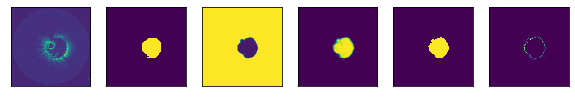

In [58]:
analysis.show_a_pred(sorted_dices['path'][380])

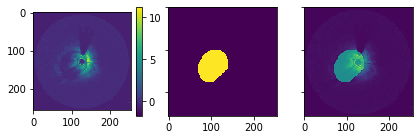

In [59]:
oct_data_v.visualise(257)

In [60]:
(dice['dice']>0.92).sum()/2403

0.9521431543903454

(array([2.000e+00, 2.000e+00, 6.000e+00, 1.000e+00, 4.000e+00, 7.000e+00, 8.000e+00, 2.700e+01, 9.700e+01, 2.249e+03]),
 array([0.412409, 0.470717, 0.529025, 0.587333, 0.645641, 0.703948, 0.762256, 0.820564, 0.878872, 0.93718 , 0.995488]),
 <a list of 10 Patch objects>)

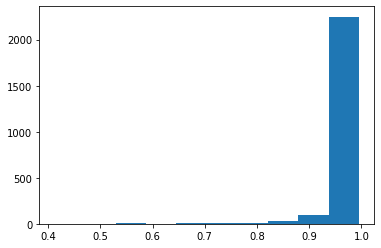

In [61]:
plt.hist(dice['dice'])

this cell below plots the over estimate residual prediction, tune the > value to modulate how much is captured in the residual

0009684.jpg


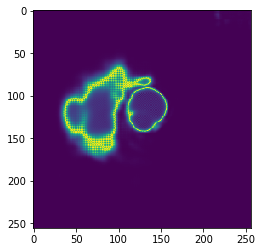

In [87]:
sample = oct_data_v[1309]
print(sample['case_name'][0])
dummy_in = (sample['input'].unsqueeze(0)).cuda()
dummy_out = model(dummy_in)[0]
plt.imshow((1-((dummy_out[0][1]-dummy_out[0][0])**2)**0.5))

In [64]:
%%time
uncdata = pd.DataFrame(columns=['mean', 'std', 'sum', 'l_area','pred_area', 'met1', 'met2'])
for i, sample in enumerate(oct_load_v): 
    xb, yb, name = sample['input'].cuda(), sample['label'].cuda(), sample['case_name'][0][0]
    
    pred = model(xb)[0]
    '''
    argp = pred[0][0] * (1 - pred.argmin(dim=1)[0].float())
    argi = argp.sum().cpu()
    
    argabsolute = (argp>0.05).sum().cpu()'''
    
    met1 = float(((1-pred.argmin(dim=1)[0]).float()*(1-(((pred[0][1]-pred[0][0])**2)**0.5))).sum())
    met2 = float(((1-((pred[0][1]-pred[0][0])**2))>0.5).sum())
    area = float(pred.argmin(dim=1)[0].sum())
    
    #larea = area - met
    #uarea = area + met
    
    
    #argp = (pred[0][0]+pred[0][1])**2
    uncdata.loc[name] = [float(pred[0][0].mean().cpu()),
                         float(pred[0][0].std().cpu()),
                         float(pred[0][0].sum().cpu()),
                         float(yb.sum()),
                        float(area),
                        float(met1),
                        float(met2)]

CPU times: user 25min 28s, sys: 2min 19s, total: 27min 48s
Wall time: 4min 38s


In [65]:
uncdata

,mean,std,sum,l_area,pred_area,met1,met2
0010696.jpg,0.122020,0.305096,7996.697754,9028.0,7875.0,1126.610107,2414.0
0001343.jpg,0.103825,0.291343,6804.256836,6824.0,7003.0,530.424438,992.0
0007889.jpg,0.056139,0.217791,3679.155029,3706.0,3747.0,441.082550,685.0
0007897.jpg,0.059208,0.224016,3880.288086,3809.0,3958.0,431.650909,681.0
0002507.jpg,0.120273,0.310487,7882.195312,8240.0,7987.0,619.240112,1150.0
...,...,...,...,...,...,...,...
0001256.jpg,0.229940,0.401573,15069.347656,15117.0,15324.0,856.533813,1603.0
0006029.jpg,0.070708,0.242952,4633.909180,4679.0,4710.0,501.362244,879.0
0011017.jpg,0.036541,0.175210,2394.726562,2382.0,2414.0,396.517181,557.0
0006996.jpg,0.127583,0.315166,8361.263672,8674.0,8391.0,848.085205,1961.0


In [66]:
uncdata = uncdata.join(dice)

(array([158., 593., 742., 496., 220., 109.,  38.,  19.,  20.,   8.]),
 array([  692. ,  2416.1,  4140.2,  5864.3,  7588.4,  9312.5, 11036.6, 12760.7, 14484.8, 16208.9, 17933. ]),
 <a list of 10 Patch objects>)

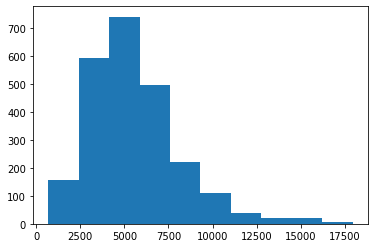

In [95]:
plt.hist(uncdata['l_area'])

In [93]:
(uncdata['met1']/uncdata['pred_area']).max()

0.8577062148955821

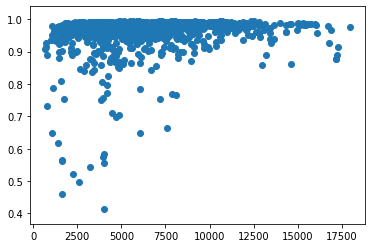

In [94]:
plt.scatter(uncdata['l_area'],uncdata['dice'])

if an image has a met of <0.4, what is that chance it will be >93% dice? about 94%... not bad!

In [97]:
(((uncdata['met']/uncdata['area'])<0.4) * uncdata['dice']>0.93).sum()/2403

0.9429879317519767

if you just let the model rip, what percentage of images have a dice >93%?

In [99]:
(uncdata['dice']>0.93).sum() /2403

0.943404078235539

### Important

np.log((uncdata['umet']+uncdata['lmet'])/uncdata['area']) is a measure of uncertainty the model has. 

it is the log of the sum of the upper and lower prediction bounds for each

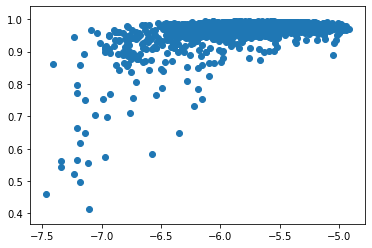

In [195]:
plt.scatter(1-np.log((uncdata['met2'])), uncdata['dice'])

In [73]:
from sklearn.linear_model import LinearRegression

In [74]:
reg = LinearRegression().fit(np.array((uncdata['pred_area'])).reshape(-1,1), uncdata['l_area'])

In [75]:
reg.score(np.array((uncdata['pred_area'])).reshape(-1,1), uncdata['l_area'])

0.967581186510957

## Plots for the paper

get the 5 worst, median and best segments

In [174]:
which_ones = sorted_dices['path'][5:10].append(sorted_dices['path'][1200:1205]).append(sorted_dices['path'][-6:-1]);

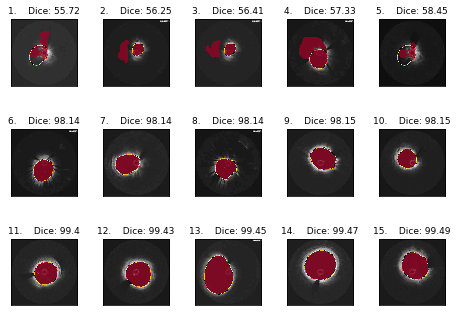

In [175]:
analysis.worst_to_best(which_ones, sorted_dices, True)

In [83]:
four = sorted_dices['path'][[
                      '0009181.jpg',
                      '0011011.jpg',
                      '0002096.jpg',
                      '0002089.jpg',
                      '0010132.jpg',
                      '0001134.jpg',
                      '0002081.jpg',
                        '0009684.jpg']]
four = four[[0,2,4,-1]]

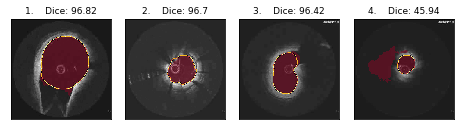

In [85]:
analysis.show_interestingx4(four, sorted_dices, False)

In [222]:
(97.12-58.45)/4.17

9.273381294964029